In [ ]:
import numpy as np
import pandas as pd
import string
import re
import os
from transformers import AutoModel
from transformers import AutoTokenizer

In [ ]:
!pip install -U accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 2.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
!pip install -U transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
suffix = 'drive/MyDrive/medical_dataset_analysis/'

beth_file_directory = 'concept_assertion_relation_training_data/beth/txt/'
beth_concept_directory = 'concept_assertion_relation_training_data/beth/concept/'

partner_file_directory = 'concept_assertion_relation_training_data/partners/txt/'
partner_concept_directory = 'concept_assertion_relation_training_data/partners/concept/'

test_directory = 'test_data/'
test_directory_concepts = 'reference_standard_for_test_data/concepts/'

In [ ]:
def getNotes(file_directory):
    text_dict = {}
    file_list = os.listdir(suffix+file_directory)
    for f in file_list:
        if f[-3:] != 'xml' and f[-3:] != 'txt' and f[-3:] != 'con':
            file_list.remove(f)
    if '.DS_Store' in file_list:
        file_list.remove('.DS_Store')
    for file_name in file_list:
        with open(suffix+file_directory + file_name,'r') as file:
            data = file.read()
            text_dict[file_name[:-4]] = data
        file.close()
    return text_dict

In [ ]:
beth_notes = getNotes(beth_file_directory)
beth_concepts = getNotes(beth_concept_directory)
partners_notes = getNotes(partner_file_directory)
partners_concepts = getNotes(partner_concept_directory)

In [ ]:
train_notes = beth_notes.copy()
train_notes.update(partners_notes)
all_notes = train_notes.copy()
train_records = list(train_notes.keys())

train_concepts = beth_concepts.copy()
train_concepts.update(partners_concepts)
all_concepts = train_concepts.copy()
train_concepts_records = list(train_concepts.keys())

test_notes = getNotes(test_directory)
test_notes_records = list(test_notes.keys())
test_concepts = getNotes(test_directory_concepts)
test_concepts_records = list(test_concepts.keys())

all_notes.update(test_notes)
all_concepts.update(test_concepts)

In [ ]:
train_notes['record-21']

"01909607\nAdmission Date :\n2010-06-28\nDischarge Date :\n2010-07-01\nDate of Birth :\n1990-02-01\nSex :\nF\nService :\nORTHOPEDIC\nHISTORY OF THE PRESENT ILLNESS :\nThis is a 20-year-old female with no significant past medical history , who was the unrestrained passenger in a high speed rollover motor vehicle accident on 2010-06-27 .\nBy report , the patient was ejected from the vehicle on impact and found curled in the fetal position at the rear of the vehicle at the scene .\nThe vehicle was noted to be extensively damaged .\nBy report , the patient was noted to be awake , but confused at the scene of the accident with no memory of the incident .\nShe was immobilized in the C-spine collar at the scene of the accident and subsequently transported by EMS to the New England Sinai Hospital & Rehab Center Emergency Department for further management .\nPHYSICAL EXAMINATION :\nExamination on presentation to the emergency room revealed the following :\nTemperature 35.4 Celsius , blood press

In [ ]:
train_concepts['record-21']

'c="left transverse mid shaft radial fracture" 90:1 90:6||t="problem"\nc="ulnar displacement" 90:8 90:9||t="problem"\nc="ap and lateral compression" 33:7 33:10||t="test"\nc="bun" 55:27 55:27||t="test"\nc="erythema" 79:22 79:22||t="problem"\nc="apparent distress" 21:10 21:11||t="problem"\nc="a 5 cm laceration" 34:0 34:3||t="problem"\nc="further inspection" 34:12 34:13||t="test"\nc="exposed underlying bone" 34:16 34:18||t="problem"\nc="a left upper extremity splint" 80:13 80:17||t="treatment"\nc="her c-spine collar" 65:11 65:13||t="treatment"\nc="a left radial fracture open reduction" 66:18 66:23||t="treatment"\nc="erythema" 72:3 72:3||t="problem"\nc="left upper extremity examination" 36:0 36:3||t="test"\nc="decreased sensation in the ulnar-nerve distribution" 36:44 36:49||t="problem"\nc="gross deformities" 36:6 36:7||t="problem"\nc="tenderness" 36:9 36:9||t="problem"\nc="right thigh hematoma" 61:29 61:31||t="problem"\nc="a duplex evaluation of the right lower extremity" 63:8 63:15||t="t

In [ ]:
def get_tags(record):
  note = all_notes[record].split('\n')
  number_of_lines = len(note)

  all_note = []
  all_tag = []
  note_lines = [n.split() for n in note]
  tag_list = [['O' for j in i] for i in note_lines]

  concept_lines = all_concepts[record].split('\n')
  for i in concept_lines:
    if len(i) > 0:

      # print(i)
      c = re.findall(r'c=\".+"',i)
      stuff = re.findall('[0-9]{1,3}:[0-9]{1,3}\s[0-9]{1,3}:[0-9]{1,3}\|\|',i)[0]

      line = re.findall(r'[0-9]{1,3}:',stuff)
      line1 = int(line[0][:-1])
      line2 = int(line[1][:-1])

      indexes = re.findall(r':[0-9]{1,3}',stuff)
      ind1 = int(indexes[0][1:])
      ind2 = int(indexes[1][1:])

      t = re.findall(r't=\"[a-z]+\"',i)
      tag = t[0][3:-1]

      for line in range(line1,line2+1):
        for index in range(ind1,ind2+1):
          if line==line1 and index==ind1:
            tag_list[line-1][index] = 'B' + '-' + tag
          else:
            tag_list[line-1][index] = 'I' + '-' + tag

  for t in tag_list:
    for ti in t:
      all_tag.append(ti)

  for n in note_lines:
    for ni in n:
      all_note.append(ni)
  return all_note, all_tag

records_dict = {}
for record in all_notes.keys():
  note,tag = get_tags(record)
  the_dict = {'words':note,'tags':tag}
  records_dict[record] = the_dict

In [ ]:
print(records_dict['record-21']['words'])
print(records_dict['record-21']['tags'])

['01909607', 'Admission', 'Date', ':', '2010-06-28', 'Discharge', 'Date', ':', '2010-07-01', 'Date', 'of', 'Birth', ':', '1990-02-01', 'Sex', ':', 'F', 'Service', ':', 'ORTHOPEDIC', 'HISTORY', 'OF', 'THE', 'PRESENT', 'ILLNESS', ':', 'This', 'is', 'a', '20-year-old', 'female', 'with', 'no', 'significant', 'past', 'medical', 'history', ',', 'who', 'was', 'the', 'unrestrained', 'passenger', 'in', 'a', 'high', 'speed', 'rollover', 'motor', 'vehicle', 'accident', 'on', '2010-06-27', '.', 'By', 'report', ',', 'the', 'patient', 'was', 'ejected', 'from', 'the', 'vehicle', 'on', 'impact', 'and', 'found', 'curled', 'in', 'the', 'fetal', 'position', 'at', 'the', 'rear', 'of', 'the', 'vehicle', 'at', 'the', 'scene', '.', 'The', 'vehicle', 'was', 'noted', 'to', 'be', 'extensively', 'damaged', '.', 'By', 'report', ',', 'the', 'patient', 'was', 'noted', 'to', 'be', 'awake', ',', 'but', 'confused', 'at', 'the', 'scene', 'of', 'the', 'accident', 'with', 'no', 'memory', 'of', 'the', 'incident', '.', 'Sh

In [ ]:
train_data = [records_dict[i] for i in train_records]
test_data = [records_dict[i] for i in test_notes_records]
df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 26.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
X_train = df_train['words']
y_train = df_train['tags']

X_test = df_test['words']
y_test = df_test['tags']

tags = ['O',
    'B-test',
    'I-test',
    'B-problem',
    'I-problem',
    'B-treatment',
    'I-treatment']


info_dict_train = {}
info_dict_train['id'] = list(map(str,list(df_train.index)))
info_dict_train['tokens'] = list(X_train.values)
info_dict_train['ner_tags'] = list(y_train.values)

info_dict_test = {}
info_dict_test['id'] = list(map(str,list(df_test.index)))
info_dict_test['tokens'] = list(X_test.values)
info_dict_test['ner_tags'] = list(y_test.values)

from datasets import Dataset, Sequence, ClassLabel

dataset_train = Dataset.from_dict(info_dict_train)
dataset_train = dataset_train.cast_column('ner_tags', Sequence(ClassLabel(names=tags)))

dataset_test = Dataset.from_dict(info_dict_test)
dataset_test = dataset_test.cast_column('ner_tags', Sequence(ClassLabel(names=tags)))


Casting the dataset:   0%|          | 0/170 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

In [ ]:
# checkpoint = 'dmis-lab/biobert-v1.1'

checkpoint= 'google-bert/bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(checkpoint,model_max_length=512)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
tokenized_input = tokenizer(records_dict['record-21']['words'], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
word_ids = tokenized_input.word_ids()
aligned_labels = [-100 if i is None else records_dict['record-21']['tags'][i] for i in word_ids]

assert len(aligned_labels) == len(tokenized_input["input_ids"])

Token indices sequence length is longer than the specified maximum sequence length for this model (1905 > 512). Running this sequence through the model will result in indexing errors


In [ ]:

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True, max_length=512,
                                stride=3, return_overflowing_tokens=True
                                 )

    sample_map = tokenized_inputs.pop("overflow_to_sample_mapping")
    for key, values in examples.items():
        tokenized_inputs[key] = [values[i] for i in sample_map]

    labels = []
    for i, label in enumerate(tokenized_inputs["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)

        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
tokenized_train = dataset_train.map(tokenize_and_align_labels,batched=True)
tokenized_test = dataset_test.map(tokenize_and_align_labels,batched=True)

Map:   0%|          | 0/170 [00:00<?, ? examples/s]

Map:   0%|          | 0/256 [00:00<?, ? examples/s]

In [ ]:
train_validation = tokenized_train.train_test_split(test_size= 0.2, seed=42)

In [ ]:
from datasets import DatasetDict
final_dataset = DatasetDict({
    'train': train_validation['train'],
    'validation':train_validation['test'],
    'test': tokenized_test
})

In [ ]:
final_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 396
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 876
    })
})

In [ ]:
ner_feature = final_dataset["train"].features["ner_tags"]

In [ ]:
label_names = ner_feature.feature.names

In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer,return_tensors='pt')

In [ ]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 532.4 kB/s eta 0:00:00


In [ ]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=0f4c1bf2c1522d2079898a9632c9c626f4354ae80efed049b38c9f71abf8b398
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
import evaluate

metric = evaluate.load('seqeval')

In [ ]:
labels = final_dataset["train"][0]["ner_tags"]
labels = [label_names[i] for i in labels]

In [ ]:
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    mlb = MultiLabelBinarizer()
    true_labels_binary = mlb.fit_transform(true_labels)
    # true_labels_binary = np.array(true_labels_binary)
    # true_labels_binary = true_labels_binary.astype(int)
    true_predictions_binary = mlb.transform(true_predictions)
    # true_predictions_binary = np.array(true_predictions_binary)
    # true_predictions_binary = true_predictions_binary.astype(int)

    cr = classification_report(MultiLabelBinarizer().fit_transform(true_labels),MultiLabelBinarizer().fit_transform(true_predictions))

    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    f1_individual = f1_score(true_labels_binary,true_predictions_binary,average=None)
    return {
        "f1": all_metrics["overall_f1"],
        "f1_O": f1_individual[0],
        "f1_B_test": f1_individual[1],
        "f1_I_test": f1_individual[2],
        "f1_B_problem": f1_individual[3],
        "f1_I_problem": f1_individual[4],
        "f1_B_treatment": f1_individual[5],
        "f1_I_treatment": f1_individual[6],
        "classification_report": cr
    }

NameError: name 'true_labels_binary' is not defined

In [ ]:
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

In [ ]:
#
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForTokenClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install transformers[torch]

In [ ]:
!pip install accelerate -U

In [ ]:
# hyperparameters: optimizer, weight_decay, learning_rate, batch_size
from transformers import TrainingArguments
from transformers import EarlyStoppingCallback, IntervalStrategy

args = TrainingArguments(
    checkpoint,
    evaluation_strategy=IntervalStrategy.STEPS,
    eval_steps = 50,
    save_total_limit = 5,
    learning_rate=2e-5,
    num_train_epochs=20,
    weight_decay=0.01,
    logging_steps=1,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True,
    seed = 42
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=final_dataset["train"],
    eval_dataset=final_dataset["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]
)
trainer.train()

Step,Training Loss,Validation Loss,F1,F1 O,F1 B Test,F1 I Test,F1 B Problem,F1 I Problem,F1 B Treatment,F1 I Treatment,Classification Report
50,0.481200,0.417500,0.475269,0.983607,0.891720,0.960894,0.988636,0.870748,0.750000,1.000000,precision recall f1-score support 0 1.00 0.97 0.98 93 1 0.92 0.86 0.89 81 2 0.97 0.96 0.96 90 3 0.99 0.99 0.99 88 4 0.96 0.80 0.87 80 5 0.98 0.61 0.75 84 6 1.00 1.00 1.00 100 micro avg 0.98 0.89 0.93 616 macro avg 0.97 0.88 0.92 616 weighted avg 0.97 0.89 0.93 616 samples avg 0.97 0.89 0.92 616
100,0.178000,0.229446,0.686492,1.000000,0.950000,0.972067,0.994350,0.962500,0.939024,1.000000,precision recall f1-score support 0 1.00 1.00 1.00 93 1 0.96 0.94 0.95 81 2 0.98 0.97 0.97 90 3 0.99 1.00 0.99 88 4 0.96 0.96 0.96 80 5 0.96 0.92 0.94 84 6 1.00 1.00 1.00 100 micro avg 0.98 0.97 0.98 616 macro avg 0.98 0.97 0.97 616 weighted avg 0.98 0.97 0.98 616 samples avg 0.98 0.96 0.97 616
150,0.159200,0.202821,0.751373,0.994595,0.943396,0.966292,0.988636,0.955975,0.950617,1.000000,precision recall f1-score support 0 1.00 0.99 0.99 93 1 0.96 0.93 0.94 81 2 0.98 0.96 0.97 90 3 0.99 0.99 0.99 88 4 0.96 0.95 0.96 80 5 0.99 0.92 0.95 84 6 1.00 1.00 1.00 100 micro avg 0.98 0.96 0.97 616 macro avg 0.98 0.96 0.97 616 weighted avg 0.98 0.96 0.97 616 samples avg 0.98 0.96 0.96 616
200,0.131900,0.184629,0.772437,0.994595,0.956522,0.977778,0.982857,0.975309,0.963415,1.000000,precision recall f1-score support 0 1.00 0.99 0.99 93 1 0.96 0.95 0.96 81 2 0.98 0.98 0.98 90 3 0.99 0.98 0.98 88 4 0.96 0.99 0.98 80 5 0.99 0.94 0.96 84 6 1.00 1.00 1.00 100 micro avg 0.98 0.98 0.98 616 macro avg 0.98 0.97 0.98 616 weighted avg 0.98 0.98 0.98 616 samples avg 0.98 0.97 0.97 616
250,0.083900,0.185882,0.787584,0.994595,0.962963,0.983425,0.988636,0.975309,0.970060,1.000000,precision recall f1-score support 0 1.00 0.99 0.99 93 1 0.96 0.96 0.96 81 2 0.98 0.99 0.98 90 3 0.99 0.99 0.99 88 4 0.96 0.99 0.98 80 5 0.98 0.96 0.97 84 6 1.00 1.00 1.00 100 micro avg 0.98 0.98 0.98 616 macro avg 0.98 0.98 0.98 616 weighted avg 0.98 0.98 0.98 616 samples avg 0.98 0.98 0.98 616
300,0.056600,0.185300,0.792916,0.994595,0.962500,0.977778,0.988636,0.975309,0.970060,1.000000,precision recall f1-score support 0 1.00 0.99 0.99 93 1 0.97 0.95 0.96 81 2 0.98 0.98 0.98 90 3 0.99 0.99 0.99 88 4 0.96 0.99 0.98 80 5 0.98 0.96 0.97 84 6 1.00 1.00 1.00 100 micro avg 0.98 0.98 0.98 616 macro avg 0.98 0.98 0.98 616 weighted avg 0.98 0.98 0.98 616 samples avg 0.98 0.97 0.98 616
350,0.095300,0.191403,0.796435,0.989130,0.962963,0.977778,0.982857,0.975610,0.970060,1.000000,precision recall f1-score support 0 1.00 0.98 0.99 93 1 0.96 0.96 0.96 81 2 0.98 0.98 0.98 90 3 0.99 0.98 0.98 88 4 0.95 1.00 0.98 80 5 0.98 0.96 0.97 84 6 1.00 1.00 1.00 100 micro avg 0.98 0.98 0.98 616 macro avg 0.98 0.98 0.98 616 weighted avg 0.98 0.98 0.98 616 samples avg 0.98 0.97 0.97 616
400,0.052900,0.196016,0.798983,0.989130,0.962963,0.977778,0.982857,0.975309,0.975904,1.000000,precision recall f1-score support 0 1.00 0.98 0.99 93 1 0.96 0.96 0.96 81 2 0.98 0.98 0.98 90 3 0.99 0.98 0.98 88 4 0.96 0.99 0.98 80 5 0.99 0.96 0.98 84 6 1.00 1.00 1.00 100 micro avg 0.98 0.98 0.98 616 macro avg 0.98 0.98 0.98 616 weighted avg 0.98 0.98 0.98 616 samples avg 0.98 0.97 0.97 616
450,0.028100,0.206082,0.803239,0.994595,0.968553,0.977778,0.982857,0.981366,0.975904,1.000000,precision recall f1-score support 0 1.00 0.99 0.99 93 1 0.99 0.95 0.97 81 2 0.98 0.98 0.98 90 3 0.99 0.98 0.98 88 4 0.98 0.99 0.98 80 5 0.99 0.96 0.98 84 6 1.00 1.00 1.00 100 micro avg 0.99 0.98 0.98 616 macro avg 0.99 0.98 0.98 616 weighted avg 0.99 0.98 0.98 616 samples avg 0.99 0.97 0.98 616
500,0.035800,0.205942,0.803265,0.989130,0.968553,0.977778,0.982857,0.974684,0.975904,1.000000,precision recall f1-score support 0 1.00 0.98 0.99 93 1 0.99 0.95 0.97 81 2 0.98 0.98 0.98 90 3 0.99 0.98 0.98 88 4 0.99 0.96 0.97 80 5 0.99 0.96 0.98 84 6 1.00 1.00 1.00 100 micro avg 0.99 0.97 0.98 616 macro avg 0.99 0.97 0.98 616 weighted avg 0.99 0.97 

Trainer is attempting to log a value of "              precision    recall  f1-score   support

           0       1.00      0.97      0.98        93
           1       0.92      0.86      0.89        81
           2       0.97      0.96      0.96        90
           3       0.99      0.99      0.99        88
           4       0.96      0.80      0.87        80
           5       0.98      0.61      0.75        84
           6       1.00      1.00      1.00       100

   micro avg       0.98      0.89      0.93       616
   macro avg       0.97      0.88      0.92       616
weighted avg       0.97      0.89      0.93       616
 samples avg       0.97      0.89      0.92       616
" of type <class 'str'> for key "eval/classification_report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "              precision    recall  f1-score   support

           0       1.00      1.00      1.00

TrainOutput(global_step=1000, training_loss=0.10021997682983055, metrics={'train_runtime': 857.8012, 'train_samples_per_second': 9.233, 'train_steps_per_second': 1.166, 'total_flos': 2069006540940504.0, 'train_loss': 0.10021997682983055, 'epoch': 20.0})

In [ ]:
loss = []
learning_rate = []
epoch = []
val_loss = []
history = trainer.state.log_history
f1 = []
for step in history:
  if 'learning_rate' in step.keys() and step['step'] % 50 == 0:
    epoch.append(step['epoch'])
    learning_rate.append(step['learning_rate'])
    loss.append(step['loss'])
  elif 'eval_loss' in step.keys() and step['step'] % 50 == 0:
    val_loss.append(step['eval_loss'])
    f1.append(step['eval_f1'])
  else:
    continue

Text(0.5, 0, 'Epoch')

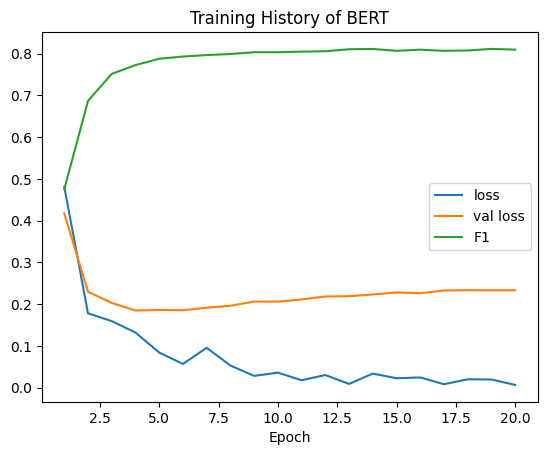

In [ ]:
import matplotlib.pyplot as plt

plt.plot(epoch,loss,label='loss')
plt.plot(epoch,val_loss,label='val loss')
#plt.plot(epoch,list(map(lambda x: x/val_loss[0],learning_rate)),label='learning rate')
plt.plot(epoch,f1,label='F1')
plt.legend(loc='center right')
plt.title('Training History of BERT')
plt.xlabel('Epoch')

In [ ]:
#trainer.save_model('model_biobert_20240406')

In [ ]:
#!zip -r /content/file.zip /content/model_biobert_20240406/

  adding: content/model_biobert_20240406/ (stored 0%)
  adding: content/model_biobert_20240406/config.json (deflated 53%)
  adding: content/model_biobert_20240406/training_args.bin (deflated 51%)
  adding: content/model_biobert_20240406/tokenizer.json (deflated 70%)
  adding: content/model_biobert_20240406/special_tokens_map.json (deflated 42%)
  adding: content/model_biobert_20240406/vocab.txt (deflated 49%)
  adding: content/model_biobert_20240406/model.safetensors (deflated 7%)
  adding: content/model_biobert_20240406/tokenizer_config.json (deflated 75%)


In [ ]:
#from google.colab import files
#files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
trainer.evaluate(final_dataset['test'])

Trainer is attempting to log a value of "              precision    recall  f1-score   support

           0       0.99      1.00      1.00       797
           1       0.98      0.98      0.98       719
           2       0.99      0.99      0.99       796
           3       0.99      0.99      0.99       763
           4       0.97      0.98      0.98       691
           5       0.98      0.98      0.98       731
           6       1.00      1.00      1.00       876

   micro avg       0.99      0.99      0.99      5373
   macro avg       0.99      0.99      0.99      5373
weighted avg       0.99      0.99      0.99      5373
 samples avg       0.99      0.99      0.99      5373
" of type <class 'str'> for key "eval/classification_report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.23957739770412445,
 'eval_f1': 0.819540265445658,
 'eval_f1_O': 0.9956112852664577,
 'eval_f1_B_test': 0.981263011797363,
 'eval_f1_I_test': 0.9886934673366834,
 'eval_f1_B_problem': 0.991486574983628,
 'eval_f1_I_problem': 0.9784172661870503,
 'eval_f1_B_treatment': 0.976775956284153,
 'eval_f1_I_treatment': 1.0,
 'eval_classification_report': '              precision    recall  f1-score   support\n\n           0       0.99      1.00      1.00       797\n           1       0.98      0.98      0.98       719\n           2       0.99      0.99      0.99       796\n           3       0.99      0.99      0.99       763\n           4       0.97      0.98      0.98       691\n           5       0.98      0.98      0.98       731\n           6       1.00      1.00      1.00       876\n\n   micro avg       0.99      0.99      0.99      5373\n   macro avg       0.99      0.99      0.99      5373\nweighted avg       0.99      0.99      0.99      5373\n samples avg       0.99    

In [ ]:
print("""
precision    recall  f1-score   support\n\n           0       0.99      1.00      1.00       797\n           1       0.98      0.98      0.98       719\n           2       0.99      0.99      0.99       796\n           3       0.99      0.99      0.99       763\n           4       0.97      0.98      0.98       691\n           5       0.98      0.98      0.98       731\n           6       1.00      1.00      1.00       876\n\n   micro avg       0.99      0.99      0.99      5373\n   macro avg       0.99      0.99      0.99      5373\nweighted avg       0.99      0.99      0.99      5373\n samples avg       0.99      0.99      0.99      5373\n
 'eval_runtime': 34.9932,
 'eval_samples_per_second': 25.033,
 'eval_steps_per_second': 3.143,
 'epoch': 20.0
 """
 )

          
precision    recall  f1-score   support

           0       0.99      1.00      1.00       797
           1       0.98      0.98      0.98       719
           2       0.99      0.99      0.99       796
           3       0.99      0.99      0.99       763
           4       0.97      0.98      0.98       691
           5       0.98      0.98      0.98       731
           6       1.00      1.00      1.00       876

   micro avg       0.99      0.99      0.99      5373
   macro avg       0.99      0.99      0.99      5373
weighted avg       0.99      0.99      0.99      5373
 samples avg       0.99      0.99      0.99      5373

 'eval_runtime': 34.9932,
 'eval_samples_per_second': 25.033,
 'eval_steps_per_second': 3.143,
 'epoch': 20.0
 
